## AuxTel test LTS-337-016 (Tracking)

In this notebook, we check the tracking accuracy of the telescope by taking a series of 20 images over a 10 minute period.  Desired specs:

| Description | Value       | Unit          |   Name     |
| :---        |    :----:   |       :----:  |       ---: |
|The Auxiliary Telescope shall have a open-loop tracking accuracy over a 10 minute interval within the tracking range of:     | 2.0       | Arcsec RMS   |Aux_Tel_Tel_Track_Error|
The Auxiliary Telescope shall have the ability to track for a minimum time of: | 10| Minutes |Aux_Tel_Max_track_time|
|The Auxiliary Telescope shall be able to track in azimuth over the angular range of:|+/- 270       | Degrees     |Aux_Tel_Az_Track_Range|
|Tracking Range in elevation shall be at least:   | 20-86.5|Degrees|Aux_Tel_El_Track_Range_High|

In [2]:
import sys, time, os, asyncio
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u
from lsst.pipe.tasks.quickFrameMeasurement import QuickFrameMeasurementTask
import lsst.daf.persistence as dafPersist

In [3]:
# Set Cerro Pachon location and observation time
location = EarthLocation.from_geodetic(lon=-70.749417*u.deg,
                                       lat=-30.244639*u.deg,
                                       height=2663.0*u.m)

In [4]:
REPO_DIR = '/project/shared/auxTel/rerun/quickLook'
butler = dafPersist.Butler(REPO_DIR)

<ipython-input-4-72007b541921>:2: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = dafPersist.Butler(REPO_DIR)
<ipython-input-4-72007b541921>:2: FutureWarning: Gen2 Butler has been deprecated (LatissMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = dafPersist.Butler(REPO_DIR)


In [ ]:
# Get the centroid data
firstExpIds = [2021060900268, 2021060900289, 2021060900310, 2021060900331, 2021060900352]
numExp = 20
positionData = {}
qm_config = QuickFrameMeasurementTask.ConfigClass()
qm = QuickFrameMeasurementTask(config=qm_config)

for firstExpId in firstExpIds:
    data = {}
    centroids = []
    els = []
    azs = []
    decs = []
    ras = []
    rotpas = []
    for i in range(numExp):
        expId = firstExpId + i
        exp = butler.get('quickLookExp', detector=0, expId=expId)
        result = qm.run(exp)
        centroids.append(result.brightestObjCentroid)
        mData = exp.getMetadata()
        els.append(mData['ELSTART'])
        azs.append(mData['AZSTART'])
        decs.append(mData['DECSTART'])
        ras.append(mData['RASTART'])
        rotpas.append(mData['ROTPA'])
    data['Elevation'] = els
    data['Azimuth'] = azs
    data['Dec'] = decs
    data['RA'] = ras
    data['ROTPA'] = rotpas
    data['Centroids'] = centroids
    positionData[firstExpId] = data

Ignoring translator header fixup of LATISS AT_O_20210609_000268: 'MJD-OBS not found'


COMMENT = [ "= '        '", "---- Date, night and basic image information ----", "= '        '", "---- Telescope info, location, observer ----", "= '        '", "---- Pointing info, etc. ----", "= '        '", "---- TAN Projection ----", "= '        '", "---- Image-identifying used to build OBS-ID ----", "= '        '", "---- Test Stand information ----", "= '        '", "---- Information from Camera (Common block) ----", "= '        '", "---- Information from Camera ----", "= '        '", "---- Filter/grating information ----", "= '        '", "---- Exposure-related information ----", "= '        '", "---- Weather information ----", "= '        '", "---- Header information ----", "= '        '", "---- Checksums ----", "---- Information from Camera per sensor ----", "= '        '", "---- Geometry from Camera ----" ]
ORIGIN = "LSST DM Header Service"
// FITS file originator
DATE = "2021-06-10T01:39:06.528"
// Creation Date and Time of File
DATE-BEG = "2021-06-10T01:39:35.668"
// Time at

Ignoring translator header fixup of LATISS AT_O_20210609_000268: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210609_000269: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210609_000270: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210609_000271: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210609_000272: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210609_000273: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210609_000274: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210609_000275: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210609_000276: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210609_000277: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210609_000278: 'MJD-OBS not found'
Ignoring translator header fixup of LATISS AT_O_20210609_000279: 

In [9]:
plateScale = exp.getWcs().getPixelScale().asArcseconds() # arcseconds/pixel
print(f"FirstExpId \t Elevation \t RMS Az \t RMS El \t RMS_tot")
for firstExpId in firstExpIds:
    el = positionData[firstExpId]['Elevation']
    centroids = np.array(positionData[firstExpId]['Centroids'])
    meanPosition = centroids.mean(axis=0)
    deviation = (centroids - meanPosition) * plateScale
    
    el = Angle(positionData[firstExpId]['Elevation'][0] * u.deg)
    az = Angle(positionData[firstExpId]['Azimuth'][0] * u.deg)
    dec = Angle(positionData[firstExpId]['Dec'][0] * u.deg)
    rotpa = Angle(positionData[firstExpId]['ROTPA'][0] * u.deg) 
    sinTheta =  np.cos(location.lat) / np.cos(dec) * np.sin(az)
    theta = Angle(np.arcsin(sinTheta))
    rotAzEl = rotpa - theta - Angle(90.0 * u.deg) 
    #print(theta.deg, rotpa.deg, rotAzEl.deg)
    rotMatrix = np.array([[np.cos(rotAzEl), -np.sin(rotAzEl)], [np.sin(rotAzEl), np.cos(rotAzEl)]])
    for i in range(len(deviation)):
        deviation[i,:] = np.dot(rotMatrix,deviation[i,:])
   
    
    
    rms = np.sqrt((deviation * deviation).mean(axis=0))
    rms_tot = np.sqrt((rms * rms).sum())
    #print(rms, rms_tot)
    
    print(f"{firstExpId} \t {el:.1f} \t {rms[0]:.3f} \t \t {rms[1]:.3f} \t \t {rms_tot:.3f}")

FirstExpId 	 Elevation 	 RMS Az 	 RMS El 	 RMS_tot
2021060900268 	 73.9 deg 	 0.173 	 	 0.927 	 	 0.943
2021060900289 	 25.9 deg 	 0.852 	 	 0.854 	 	 1.206
2021060900310 	 27.2 deg 	 1.812 	 	 0.752 	 	 1.962
2021060900331 	 28.8 deg 	 2.232 	 	 0.589 	 	 2.308
2021060900352 	 36.7 deg 	 3.271 	 	 0.521 	 	 3.312


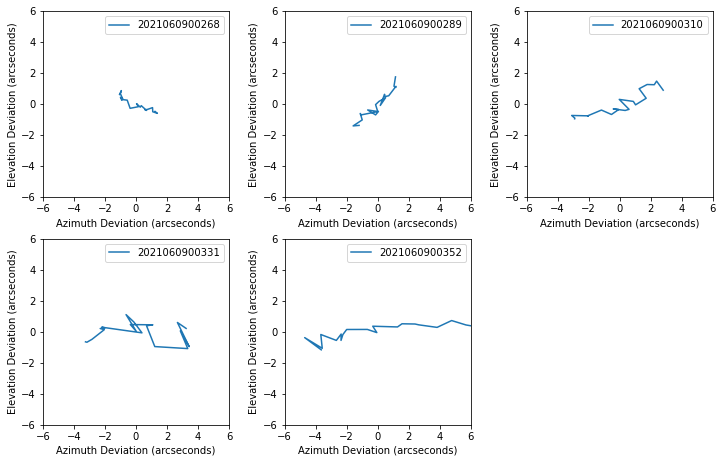

In [10]:
# What do the tracking errors look like?
# The X-error gets steadily worse.
plt.figure(figsize=(12,8))
plt.subplots_adjust(hspace=0.1,wspace=0.3)
plotcounter = 1
for firstExpId in firstExpIds:
    centroids = np.array(positionData[firstExpId]['Centroids'])
    meanPosition = centroids.mean(axis=0)
    deviation = (centroids - meanPosition) * plateScale
    plt.subplot(2,3,plotcounter, aspect=1.0)
    plt.plot(deviation[:,0], deviation[:,1], label = str(firstExpId))
    plt.xlim(-6,6)
    plt.xlabel("Azimuth Deviation (arcseconds)")
    plt.ylim(-6,6)
    plt.ylabel("Elevation Deviation (arcseconds)")    
    plt.legend()
    plotcounter += 1
#plt.savefig("/home/craiglagegit/DATA/Tracking_Plot_AzEl_15Jun21.png")

[205.56316491 205.56319286 205.56325977 205.56322642 205.56325623
 205.56329357 205.56328411 205.56340901 205.56343149 205.56342168
 205.5634363  205.56351514 205.56360059 205.56356377 205.56365395
 205.56367641 205.5636744  205.56377786 205.56374736 205.56382499]
[-45.44417112 -45.44417384 -45.44414588 -45.4440901  -45.44407372
 -45.44406032 -45.44403402 -45.4440286  -45.44402785 -45.44396667
 -45.44398007 -45.44395029 -45.44393203 -45.44388076 -45.44392723
 -45.44388504 -45.44384636 -45.44384485 -45.44383279 -45.44384523]


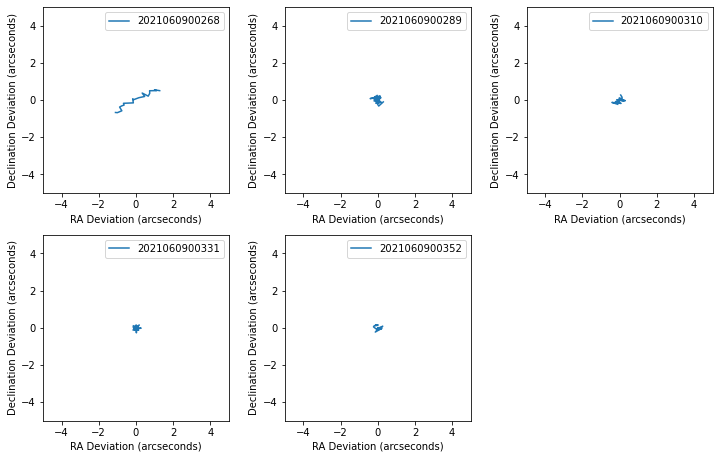

In [23]:
plt.figure(figsize=(12,8))
plt.subplots_adjust(hspace=0.1,wspace=0.3)
plotcounter = 1
for firstExpId in firstExpIds:
    ras = np.array(positionData[firstExpId]['RA'])
    decs = np.array(positionData[firstExpId]['Dec'])
    if firstExpId == 2021060900268:
        print(ras)
        print(decs)
    meanra = ras.mean()
    meandec = decs.mean()
    ra_deviation = (ras - meanra) * 3600.0
    dec_deviation = (decs - meandec) * 3600.0
    plt.subplot(2,3,plotcounter, aspect=1.0)
    plt.plot(ra_deviation, dec_deviation, label = str(firstExpId))
    plt.xlim(-5,5)
    plt.xlabel("RA Deviation (arcseconds)")
    plt.ylim(-5,5)
    plt.ylabel("Declination Deviation (arcseconds)")    
    plt.legend()
    plotcounter += 1
plt.savefig("/home/craiglagegit/DATA/RA_Dec_Deviations_17Jun21.png")

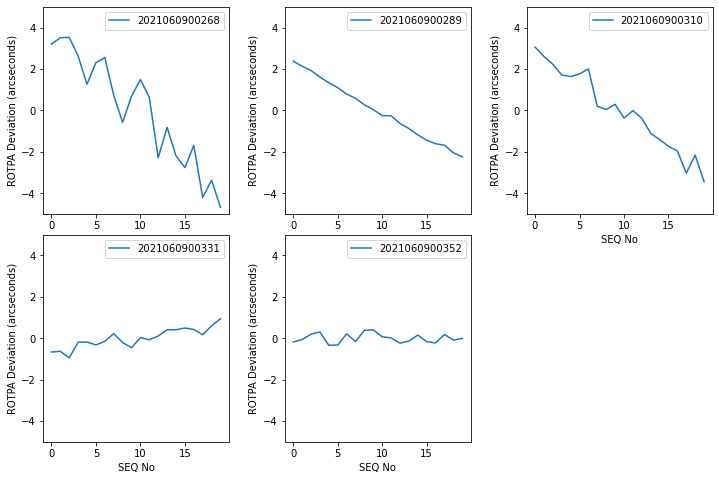

In [21]:
plt.figure(figsize=(12,8))
plt.subplots_adjust(hspace=0.1,wspace=0.3)
plotcounter = 1
xaxis = range(20)
for firstExpId in firstExpIds:
    rotpas = np.array(positionData[firstExpId]['ROTPA'])
    meanrotpa = rotpas.mean()
    rotpa_deviation = (rotpas - meanrotpa) * 3600.0
    plt.subplot(2,3,plotcounter)
    plt.plot(xaxis, rotpa_deviation, label = str(firstExpId))
    #plt.xlim(-5,5)
    plt.xlabel("SEQ No")
    plt.ylim(-5,5)
    plt.ylabel("ROTPA Deviation (arcseconds)")    
    plt.legend()
    plotcounter += 1
plt.savefig("/home/craiglagegit/DATA/ROTPA_Deviations_17Jun21.png")